In [318]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd

from scipy.signal import savgol_filter
from scipy.stats import binned_statistic


plt.rcParams['figure.dpi'] = 256
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 10

colors = ['tab:blue', 'tab:red', 'orange', 'green', 'cyan', 'magenta', 'lime']



In [319]:
def plot_training_curves(env_name, model_names):
    fig, ax = plt.subplots(nrows=2, ncols=1)
    fig.set_size_inches(8, 6)

    linewidth = 0.6
    alpha = 0.4

    for i, model_name in enumerate(model_names):
        algorithm_name, name = model_name
        data = pd.read_csv(f'./data/{env_name}/{algorithm_name}/{name}/monitor.csv', skiprows=1)

        num_bins = 100
        ep_binned_mean_r = binned_statistic(np.log10(np.arange(len(data['r'])) + 1), data['r'], 'mean', num_bins)
        ep_binned_std_r = binned_statistic(np.log10(np.arange(len(data['r'])) + 1), data['r'], 'std', num_bins)
        
        ax[0].plot(ep_binned_mean_r.bin_edges[1:], ep_binned_mean_r.statistic, 
            linewidth=linewidth, label=algorithm_name + ' ' + name, color=colors[i])
        ax[0].plot(ep_binned_mean_r.bin_edges[1:], ep_binned_mean_r.statistic + ep_binned_std_r.statistic, 
            linewidth=linewidth, color=colors[i], linestyle='--', alpha=alpha)
        ax[0].plot(ep_binned_mean_r.bin_edges[1:], ep_binned_mean_r.statistic - ep_binned_std_r.statistic, 
            linewidth=linewidth, color=colors[i], linestyle='--', alpha=alpha)

        num_bins = 100
        t_binned_mean_r = binned_statistic(np.log10(data['t']), data['r'], 'mean', num_bins)
        t_binned_std_r = binned_statistic(np.log10(data['t']), data['r'], 'std', num_bins)

        ax[1].plot(t_binned_mean_r.bin_edges[1:], t_binned_mean_r.statistic, 
            linewidth=linewidth, label=algorithm_name + ' ' + name, color=colors[i])
        ax[1].plot(t_binned_mean_r.bin_edges[1:], t_binned_mean_r.statistic + ep_binned_std_r.statistic, 
            linewidth=linewidth, color=colors[i], linestyle='--', alpha=alpha)
        ax[1].plot(t_binned_mean_r.bin_edges[1:], t_binned_mean_r.statistic - ep_binned_std_r.statistic, 
            linewidth=linewidth, color=colors[i], linestyle='--', alpha=alpha)

        # ax[1].plot(data['t'], data['r'], linewidth=linewidth, alpha=0.4, color=colors[i])

    baseline_rewards = np.load(f'./data/{env_name}/baseline/eval_rewards.npy')
    total_reward = np.mean(np.sum(baseline_rewards, axis=0))
    std_reward = np.std(np.sum(baseline_rewards, axis=0))

    ax[0].axhline(total_reward, color='blue', label='Baseline', linewidth=linewidth)
    #ax.axhline(total_reward + std_reward, color='blue', linewidth=linewidth, linestyle='--')
    #ßax.axhline(total_reward - std_reward, color='blue', linewidth=linewidth, linestyle='--')

    ax[0].legend(fontsize=6)
    ax[0].set_xlabel('Episode')
    ax[0].set_ylabel('Reward')

    ax[0].set_xlim(2, 5)
    ax[0].set_ylim(-400, 500)

    ax[1].set_xlim(1, 4)
    ax[1].set_ylim(-400, 500)

    fig.tight_layout()
    fig.show()


def plot_eval_episodes(env_name, model_names):
    fig, ax = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(8, 3)
    
    linewidth = 0.6
    alpha = 0.4

    def plot_rewards(rewards, label, color):
        reward_means = np.mean(rewards, axis=0)
        reward_stds = np.std(rewards, axis=0)

        ax[0].plot(reward_means, linewidth=linewidth, label=label, color=color)
        ax[0].plot(reward_means + reward_stds, linewidth=linewidth, color=color, linestyle='--', alpha=alpha)
        ax[0].plot(reward_means - reward_stds, linewidth=linewidth, color=color, linestyle='--', alpha=alpha)

        cumulative_rewards = np.cumsum(rewards, axis=1)
        cumulative_reward_means = np.mean(cumulative_rewards, axis=0)
        cumulative_reward_stds = np.std(cumulative_rewards, axis=0)

        ax[1].plot(cumulative_reward_means, linewidth=linewidth, label=label, color=color)
        ax[1].plot(cumulative_reward_means + cumulative_reward_stds, linewidth=linewidth, color=color, linestyle='--', alpha=alpha)
        ax[1].plot(cumulative_reward_means - cumulative_reward_stds, linewidth=linewidth, color=color, linestyle='--', alpha=alpha)

    for i, model_name in enumerate(model_names):
        algo_name, name = model_name
        rewards = np.load(f'./data/{env_name}/{algo_name}/{name}/best_model_eval_rewards.npy')

        plot_rewards(rewards, algo_name + ' ' + name, colors[i])
        

    baseline_reward = np.load(f'./data/{env_name}/baseline/eval_rewards.npy')
    plot_rewards(baseline_reward, 'Baseline', 'blue')

    ax[0].legend(fontsize=6)
    ax[0].set_xlabel('Episode')
    ax[0].set_ylabel('Reward')

    ax[1].set_xlabel('Episode')
    ax[1].set_ylabel('Cumulative Reward')

    fig.tight_layout()
    fig.show()


In [320]:
models = [('PPO', 'default'), ('A2C', 'default'), ('SAC', 'default'), 
('ARS', 'default'), ('TQC', 'default'), ('TRPO', 'default'), ('RecurrentPPO', 'default')]

/var/folders/v5/b2527n0x4zgb6khjjq0g22k40000gn/T/ipykernel_3182/744018793.py:55: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


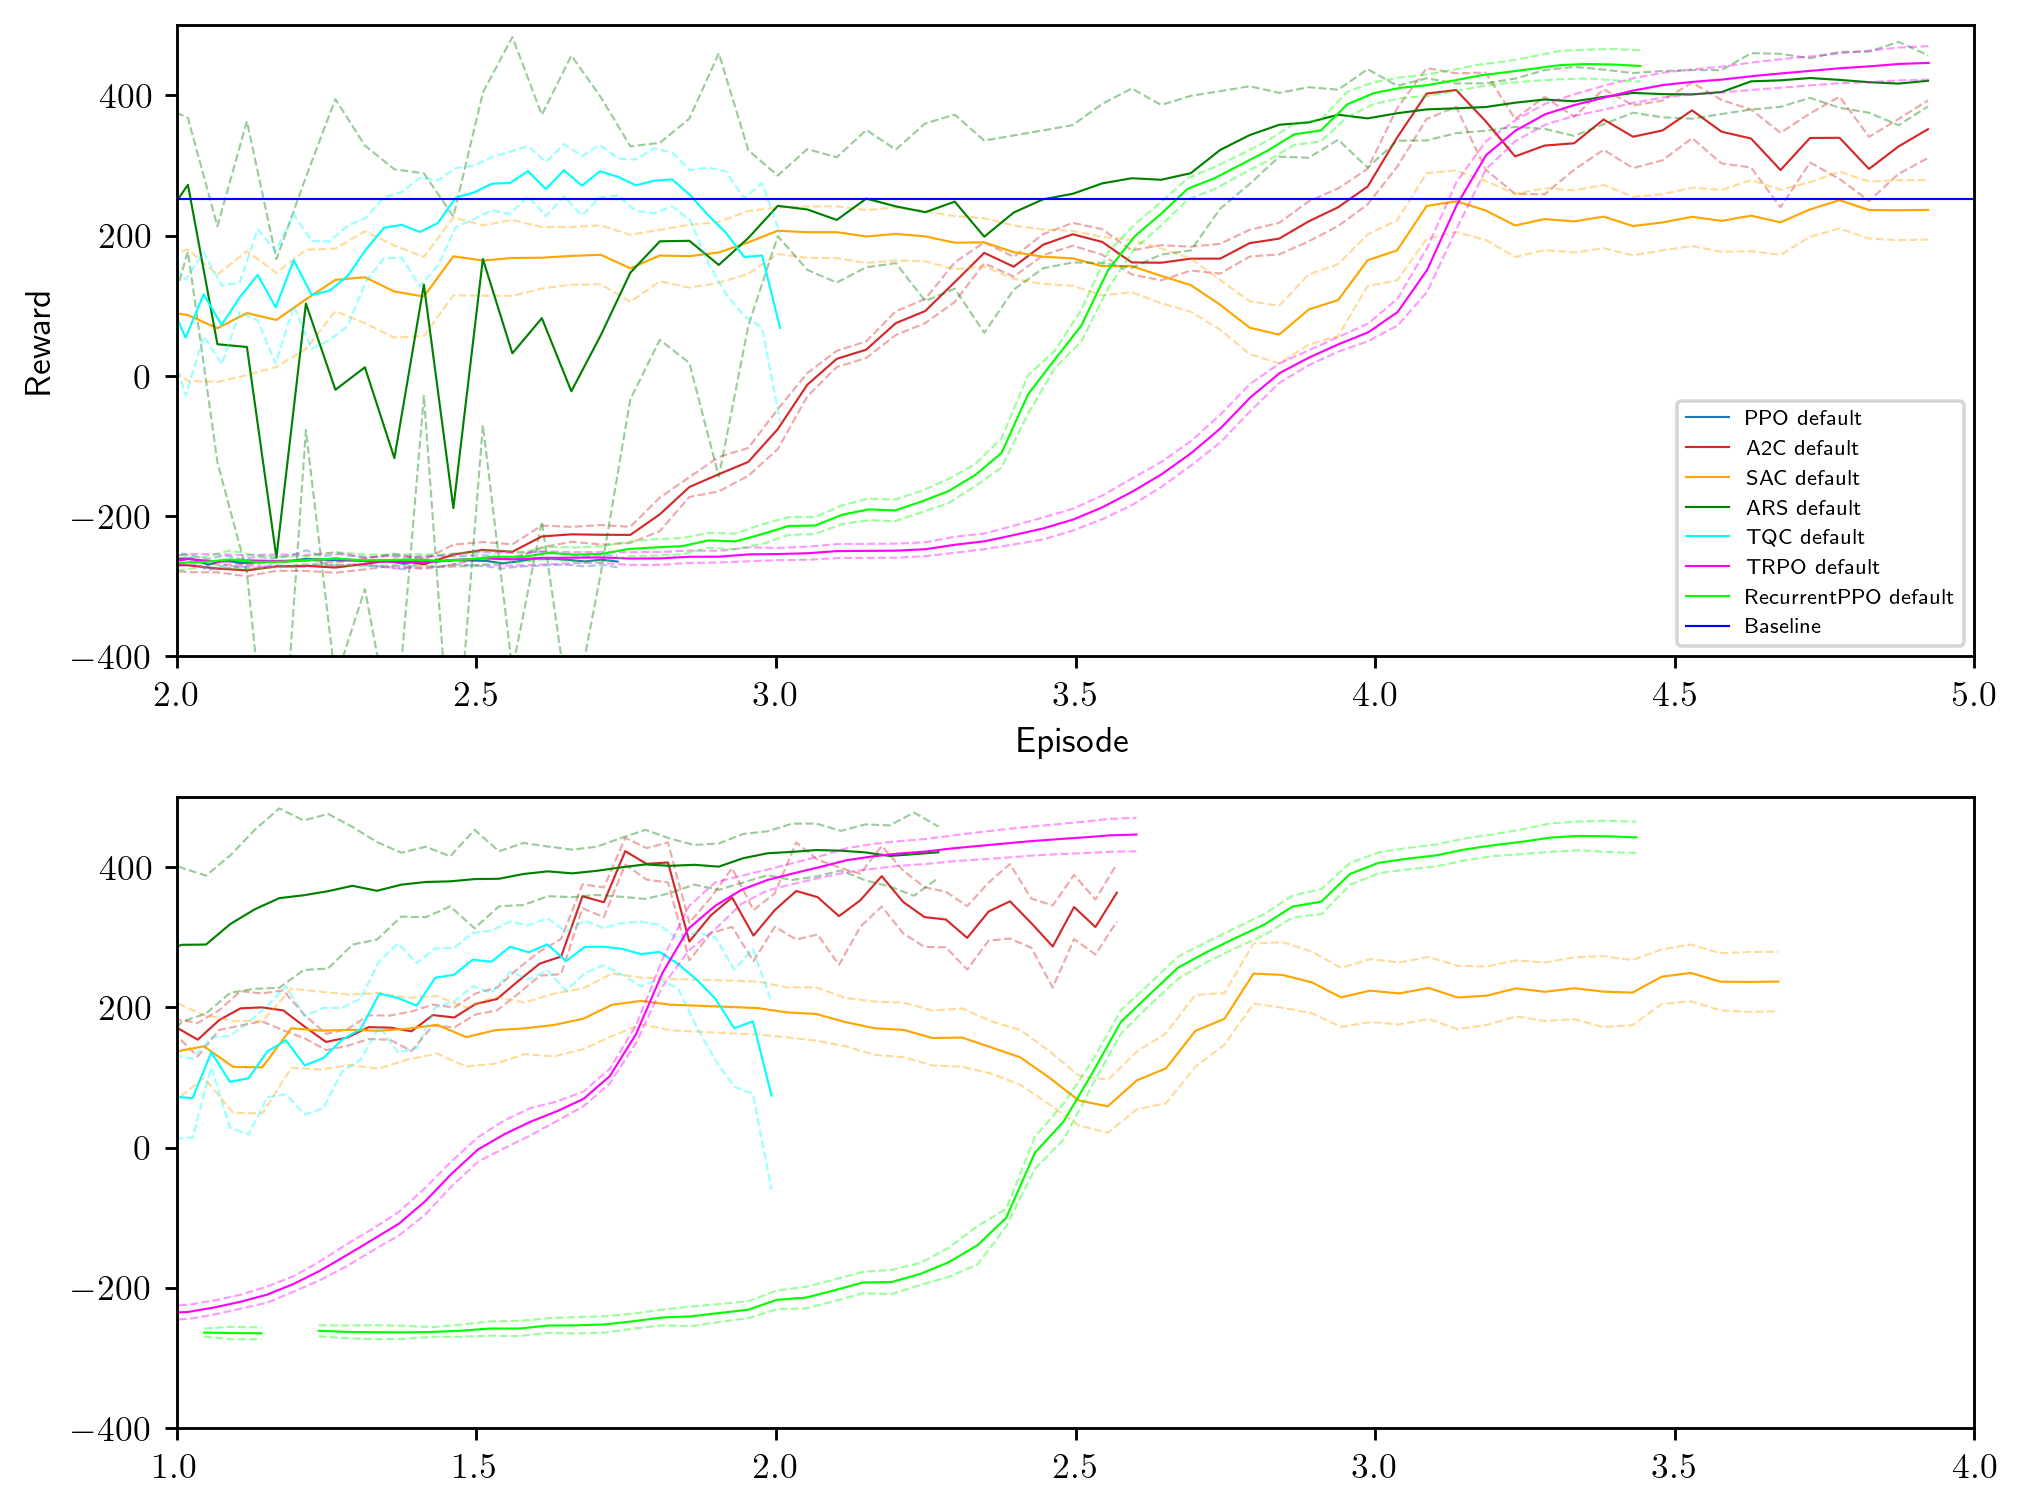

In [321]:
plot_training_curves('InvManagement-v1', models)

['timesteps', 'results', 'ep_lengths']
62
[  40000   80000  120000  160000  200000  240000  280000  320000  360000
  400000  440000  480000  520000  560000  600000  640000  680000  720000
  760000  800000  840000  880000  920000  960000 1000000 1040000 1080000
 1120000 1160000 1200000 1240000 1280000 1320000 1360000 1400000 1440000
 1480000 1520000 1560000 1600000 1640000 1680000 1720000 1760000 1800000
 1840000 1880000 1920000 1960000 2000000 2040000 2080000 2120000 2160000
 2200000 2240000 2280000 2320000 2360000 2400000 2440000 2480000]


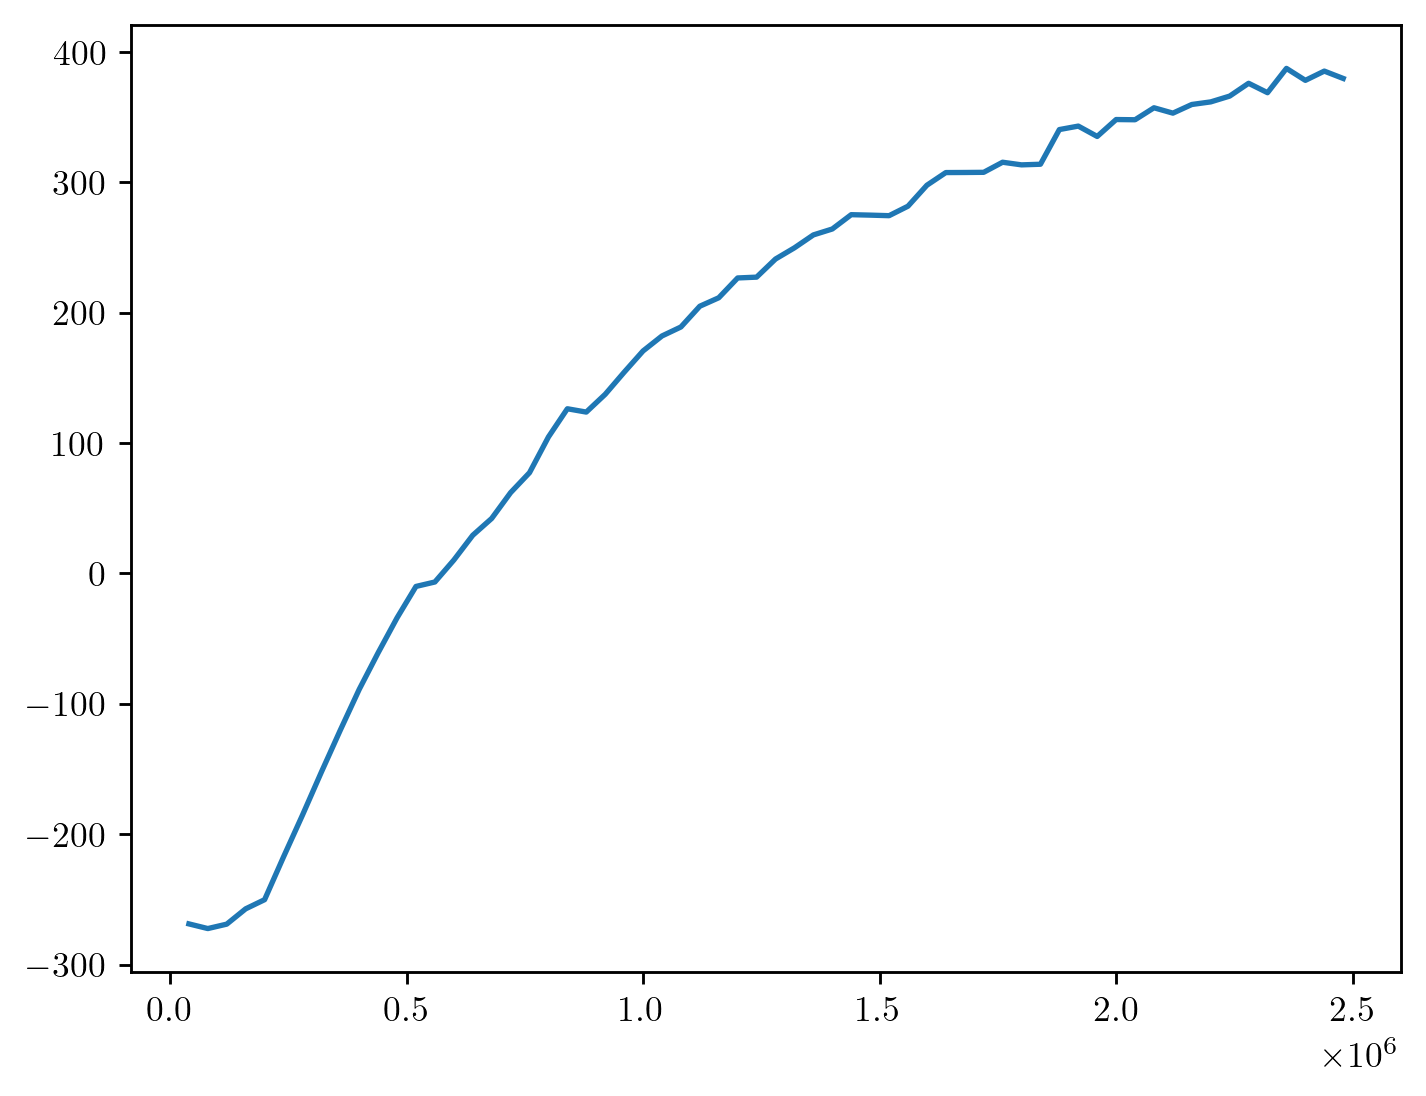

In [322]:
test = np.load('./data/InvManagement-v1/PPO/default/evaluations.npz')
print(list(test.keys()))
print(len(test['results']))
print(test['timesteps'])

t = np.array(test['timesteps'])
r = np.mean(np.array(test['results']), 1)

plt.plot(t, r)

/var/folders/v5/b2527n0x4zgb6khjjq0g22k40000gn/T/ipykernel_3182/744018793.py:99: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


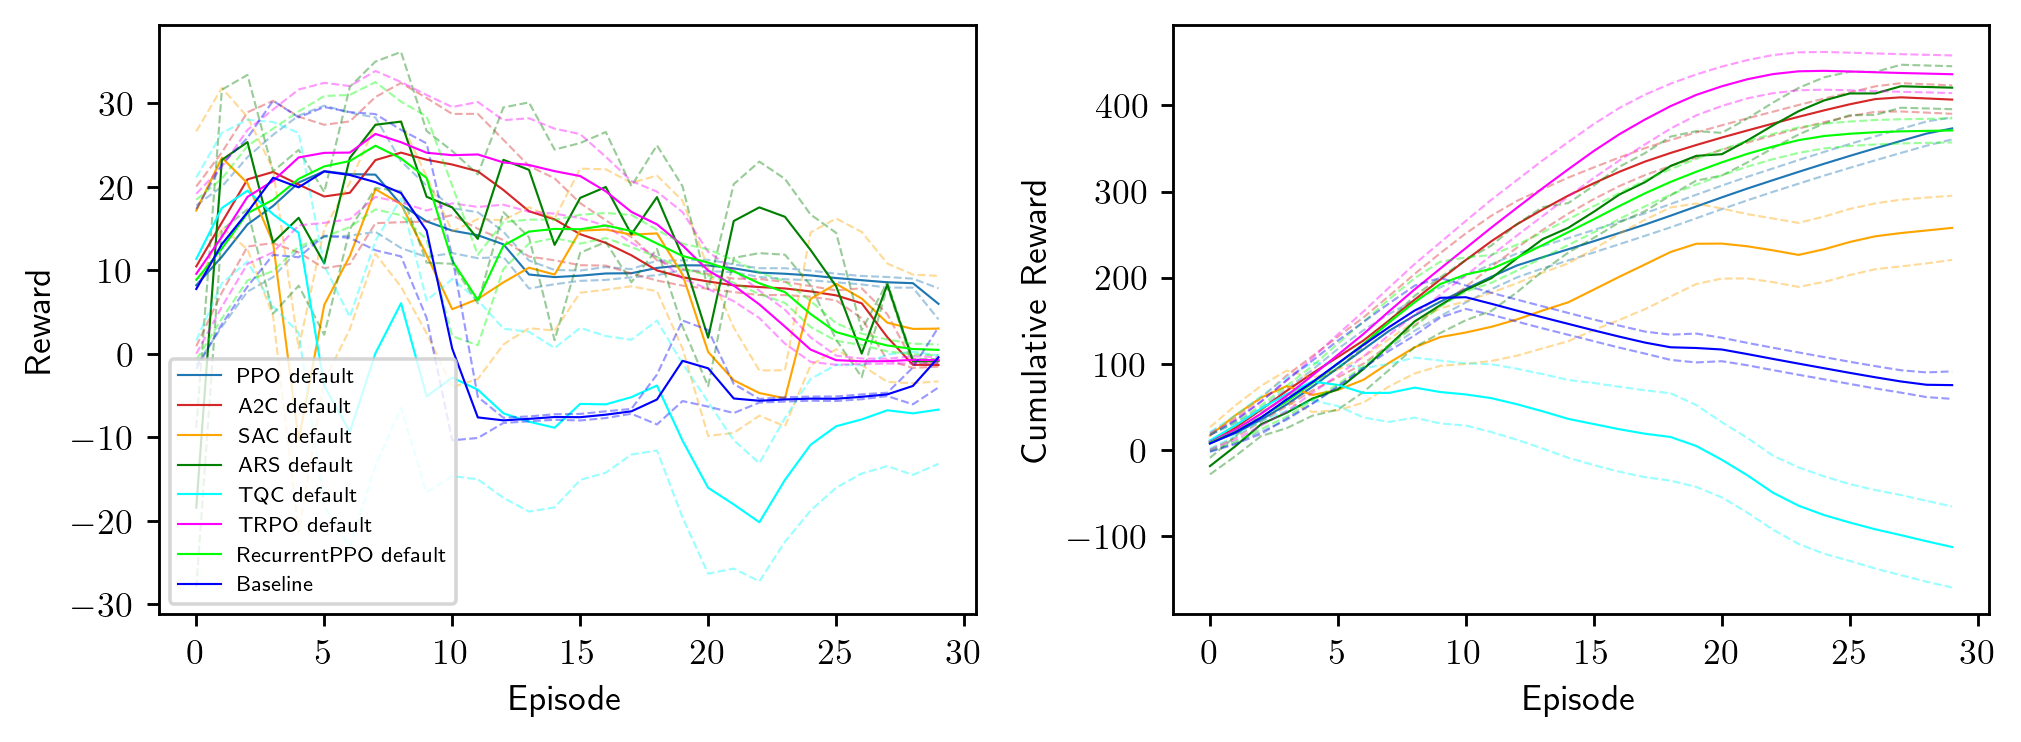

In [323]:
plot_eval_episodes('InvManagement-v1', models)